In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.optimization.simulations import pool_simulation

sns.set()
logging.basicConfig(level=logging.ERROR)

In [2]:
def plot_mean_returns(sim_returns, pos_width, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    mean_returns = pd.DataFrame(sim_returns).mean(axis=0)
    
    # assumes only numbers are the position numbers added
    x = mean_returns.index.str.findall('\d+')
    x = (np.array([int(n[0]) for n in x]) - 0.5) * pos_width
    y = mean_returns.values
    
    ax.plot(x, y, label=label)
    ax.set_title('Expected Returns by Position Range')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))
    
    return ax

def calc_returns(init_values, sim_results):
    sim_returns = []
    for results in sim_results:
        m = results['market_prices'][-1]

        end_values = {}
        pos_returns = {}
        for pid in results['pool'].account_map.keys():
            tokens = close_all_positions(results['pool'], account_id=pid)
            token0, token1, fees_token0, fees_token1 = tokens

            value = calc_token_value(token0 + fees_token0, token1 + fees_token1, m)
            end_values[pid] = value

            pos_returns[pid] = value / -init_values[pid] - 1

        sim_returns.append(pos_returns)
        
    return sim_returns


def sech2_fn(p, mu, s, c):
    # sech = 1 / cosh
    return c * (1 / np.cosh((p - mu) / s)) ** 2

In [3]:
n_sims = 10000
n_innovations = 1
n_jobs = 7

init_price = 100
fee = 0.01
pos_width = 1

SEED = 1234
num = 50
size = 1000
mu = 0.0
sigma = 0.1 

num_trades_dist = stats.poisson(num)
trade_size_dist = stats.expon(scale=size)
trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
return_dist = stats.norm(loc=mu, scale=sigma)

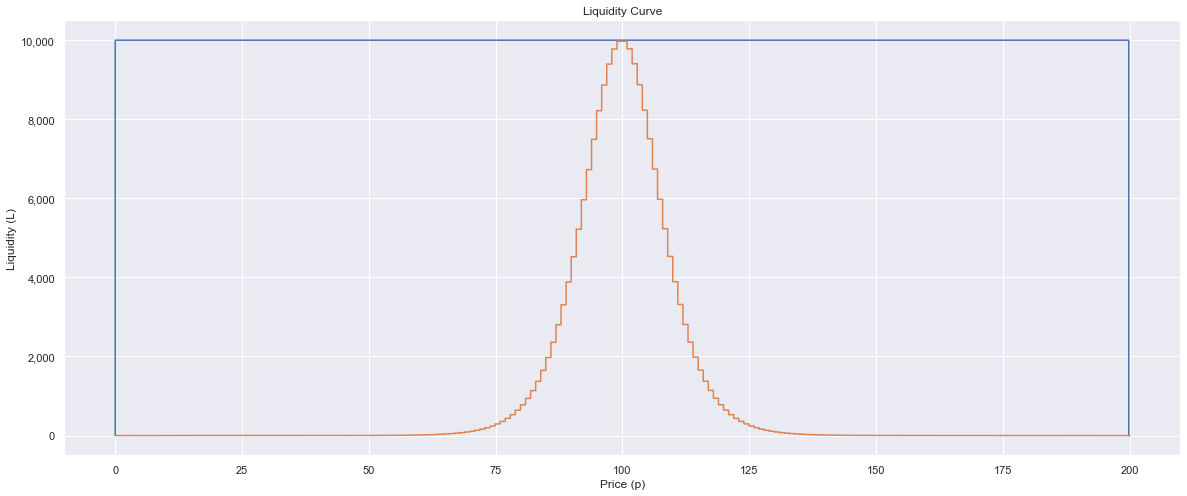

In [4]:
L = 10000
loc = 100
s = 10
c = L
liquidity_functions = [
    lambda x: L,
    lambda p: sech2_fn(p, loc, s, c)
]

fig, ax = plt.subplots(figsize=(20, 8))
for liquidity_fn in liquidity_functions:
    pool = Uniswapv3Pool(fee, 1, init_price)
    _ = set_positions(pool, liquidity_fn, pos_width, 0, 200, 
                      separate_pos=True, min_liquidity=0)
    pool.plot_liquidity_curve(ax=ax, interval=(0, 200 / 1.1))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
fig.savefig('./images/simulation_liquidity_curves.png')
plt.show()

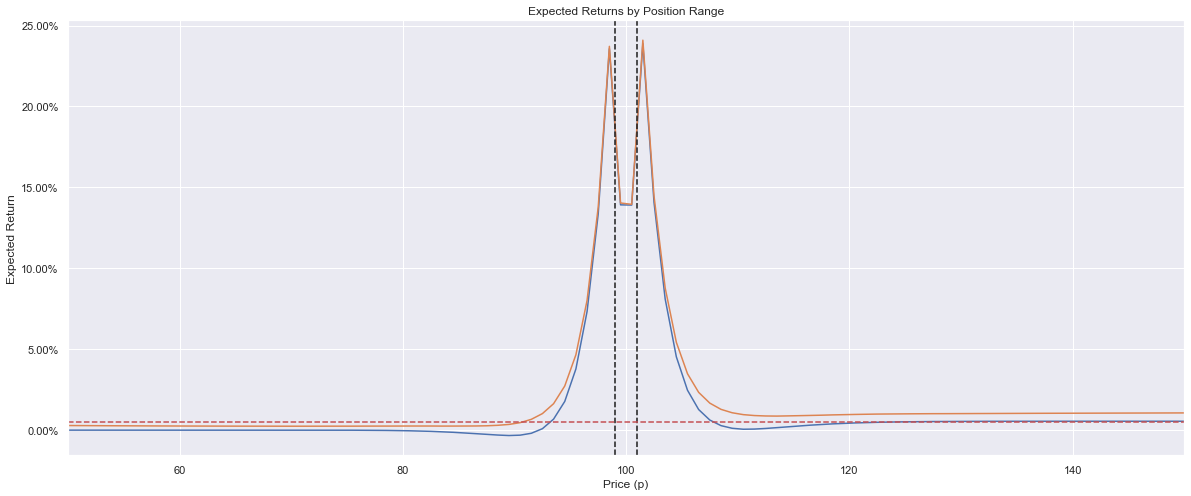

CPU times: user 4min 37s, sys: 9.58 s, total: 4min 46s
Wall time: 35min 8s


In [5]:
%%time
fig, ax = plt.subplots(figsize=(20, 8))

for liquidity_fn in liquidity_functions:
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }
    
    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax)
    
ax.set_xlim(50, 150)
ax.axvline(init_price * (1 - fee), linestyle='--', color='k')
ax.axvline(init_price / (1 - fee), linestyle='--', color='k')
ax.axhline(sigma ** 2 / 2, linestyle='--', color='r')
ax.set_ylabel('Expected Return')
ax.set_xlabel('Price (p)')

fig.savefig('./images/sim_returns_1.png')
plt.show()

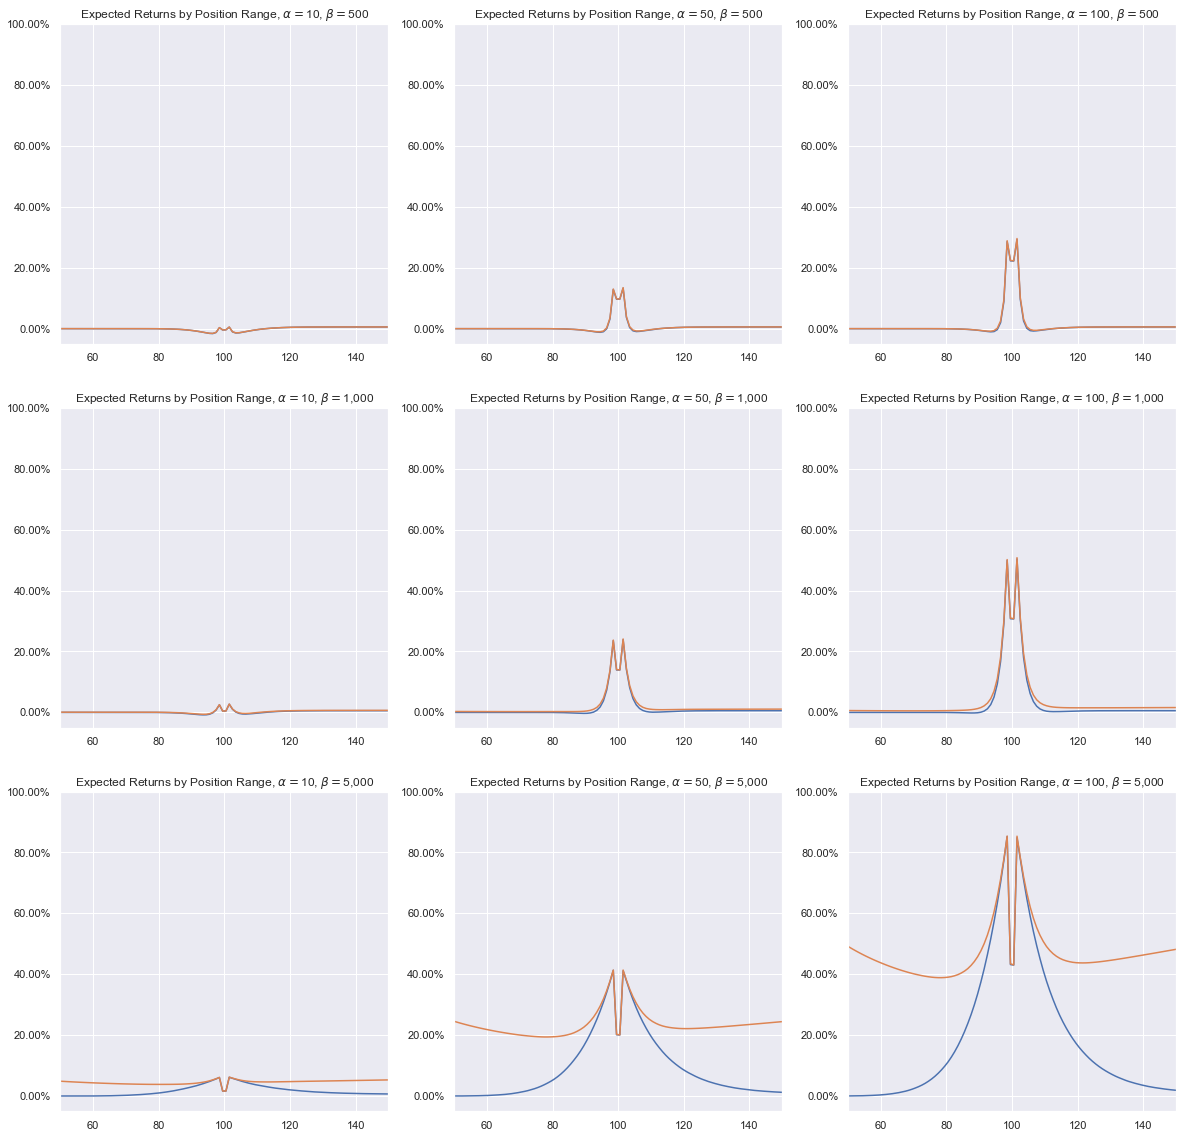

CPU times: user 42min 23s, sys: 2min 52s, total: 45min 16s
Wall time: 6h 44min 16s


In [6]:
%%time
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

num_trades = [10, 50, 100]
trade_sizes = [500, 1000, 5000]
mu = 0.0
sigma = 0.1

for i, size in enumerate(trade_sizes):
    for j, num in enumerate(num_trades):
        for liquidity_fn in liquidity_functions:
            pool = Uniswapv3Pool(fee, 1, init_price)
            init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
            init_values = {
                pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
                for pid, tdict in init_tokens.items()
            }
            
            num_trades_dist = stats.poisson(num)
            trade_size_dist = stats.expon(scale=size)
            trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
            return_dist = stats.norm(loc=mu, scale=sigma)

            sim_results = pool_simulation(
                pool, 
                num_trades_dist, 
                trade_size_dist,
                trade_sign_dist,
                return_dist,
                n_innovations=n_innovations, 
                n_sims=n_sims, 
                n_jobs=n_jobs, 
                seed=SEED
            )
            sim_returns = calc_returns(init_values, sim_results)
            plot_mean_returns(sim_returns, pos_width, ax=ax[i][j])
        
        ax[i][j].set_title(
            f'Expected Returns by Position Range, '
            f'$\\alpha=${num:,.0f}, $\\beta=${size:,.0f}'
        )
        ax[i][j].set_xlim(50, 150)
        ax[i][j].set_ylim(-0.05, 1)

fig.savefig('./images/sim_returns_2.png')
plt.show()

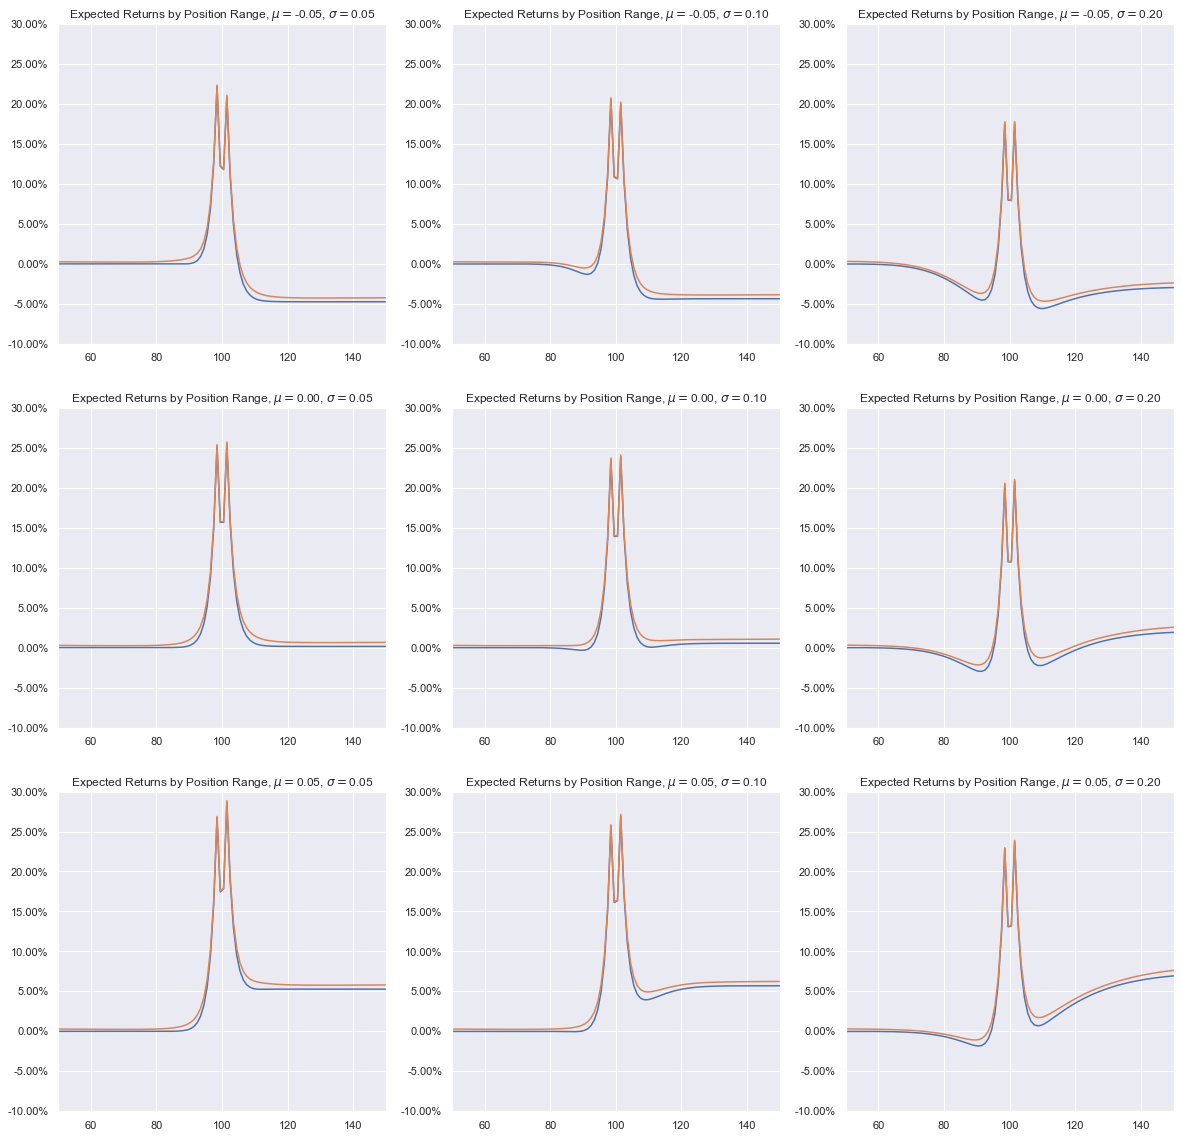

CPU times: user 41min 9s, sys: 1min 35s, total: 42min 44s
Wall time: 4h 46min 36s


In [7]:
%%time
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

num = 50
size = 1000
drifts = [-0.05, 0.00, 0.05]
vols = [0.05, 0.10, 0.2]

for i, mu in enumerate(drifts):
    for j, sigma in enumerate(vols):
        for liquidity_fn in liquidity_functions:
            pool = Uniswapv3Pool(fee, 1, init_price)
            init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
            init_values = {
                pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
                for pid, tdict in init_tokens.items()
            }
            
            num_trades_dist = stats.poisson(num)
            trade_size_dist = stats.expon(scale=size)
            trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
            return_dist = stats.norm(loc=mu, scale=sigma)

            sim_results = pool_simulation(
                pool, 
                num_trades_dist, 
                trade_size_dist,
                trade_sign_dist,
                return_dist,
                n_innovations=n_innovations, 
                n_sims=n_sims, 
                n_jobs=n_jobs, 
                seed=SEED
            )
            sim_returns = calc_returns(init_values, sim_results)
            plot_mean_returns(sim_returns, pos_width, ax=ax[i][j])
        
        ax[i][j].set_title(
            f'Expected Returns by Position Range, '
            f'$\\mu=${mu:,.2f}, $\\sigma=${sigma:,.2f}'
        )
        ax[i][j].set_xlim(50, 150)
        ax[i][j].set_ylim(-0.1, 0.3)

fig.savefig('./images/sim_returns_3.png')
plt.show()

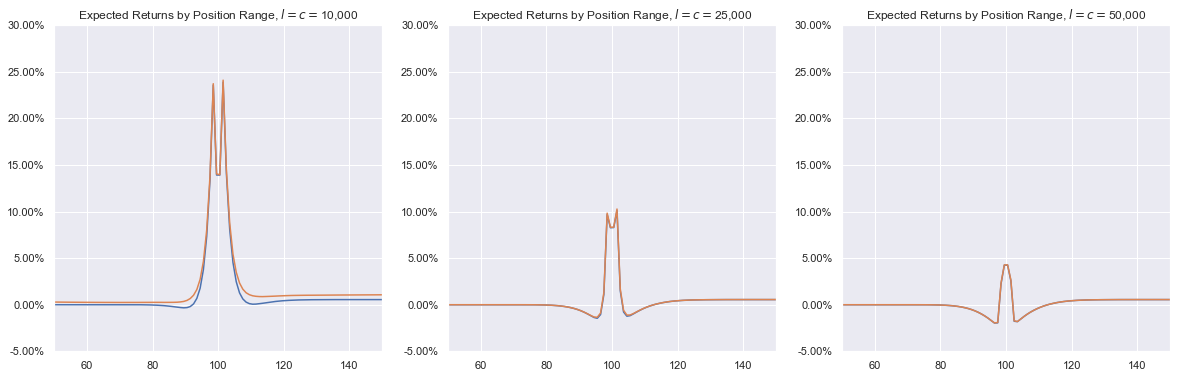

CPU times: user 14min 5s, sys: 31.8 s, total: 14min 37s
Wall time: 1h 19min 5s


In [5]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

num = 50
size = 1000
mu = 0.0
sigma = 0.1

liquidities = [10000, 25000, 50000]

for i, liquidity in enumerate(liquidities):
    num_trades_dist = stats.poisson(num)
    trade_size_dist = stats.expon(scale=size)
    trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
    return_dist = stats.norm(loc=mu, scale=sigma)
    
    # constant liquidity
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, lambda x: liquidity, 
                                pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }

    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax[i])
    
    # bell curve liquidity
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, lambda p: sech2_fn(p, loc, s, liquidity), 
                                pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }

    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax[i])

    ax[i].set_title(f'Expected Returns by Position Range, $l=c=${liquidity:,.0f}')
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(-0.05, 0.3)
    
fig.savefig('./images/sim_returns_4.png')
plt.show()

/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta


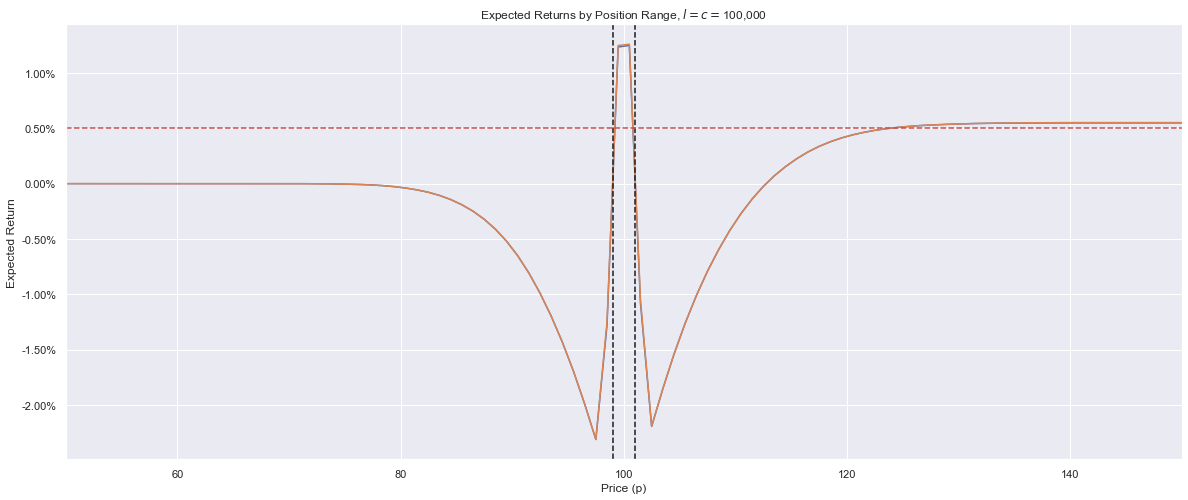

CPU times: user 4min 50s, sys: 9.94 s, total: 5min
Wall time: 17min 43s


In [6]:
%%time
num = 50
size = 1000
mu = 0.0
sigma = 0.1 

num_trades_dist = stats.poisson(num)
trade_size_dist = stats.expon(scale=size)
trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
return_dist = stats.norm(loc=mu, scale=sigma)

L = 100000
loc = 100
s = 10
c = L
liquidity_functions = [
    lambda x: L,
    lambda p: sech2_fn(p, loc, s, c)
]

fig, ax = plt.subplots(figsize=(20, 8))

for liquidity_fn in liquidity_functions:
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }
    
    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax)

ax.set_title(f'Expected Returns by Position Range, $l=c=${L:,.0f}')
ax.set_xlim(50, 150)
ax.axvline(init_price * (1 - fee), linestyle='--', color='k')
ax.axvline(init_price / (1 - fee), linestyle='--', color='k')
ax.axhline(sigma ** 2 / 2, linestyle='--', color='r')
ax.set_ylabel('Expected Return')
ax.set_xlabel('Price (p)')

fig.savefig('./images/sim_returns_5.png')
plt.show()

/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Course

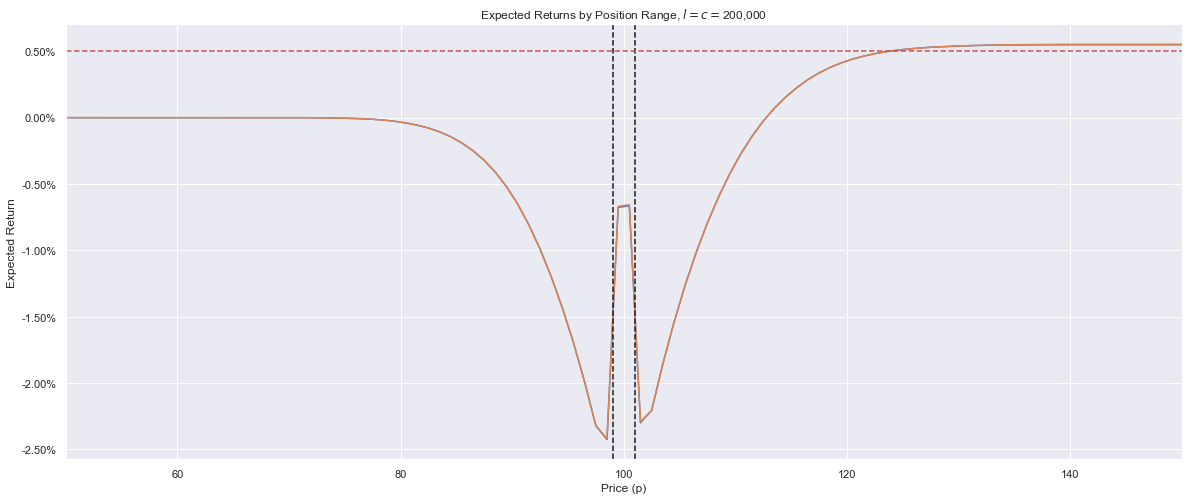

CPU times: user 4min 53s, sys: 9.86 s, total: 5min 3s
Wall time: 16min 22s


In [7]:
%%time
num = 50
size = 1000
mu = 0.0
sigma = 0.1 

num_trades_dist = stats.poisson(num)
trade_size_dist = stats.expon(scale=size)
trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
return_dist = stats.norm(loc=mu, scale=sigma)

L = 200000
loc = 100
s = 10
c = L
liquidity_functions = [
    lambda x: L,
    lambda p: sech2_fn(p, loc, s, c)
]

fig, ax = plt.subplots(figsize=(20, 8))

for liquidity_fn in liquidity_functions:
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }
    
    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax)
    
ax.set_title(f'Expected Returns by Position Range, $l=c=${L:,.0f}')
ax.set_xlim(50, 150)
ax.axvline(init_price * (1 - fee), linestyle='--', color='k')
ax.axvline(init_price / (1 - fee), linestyle='--', color='k')
ax.axhline(sigma ** 2 / 2, linestyle='--', color='r')
ax.set_ylabel('Expected Return')
ax.set_xlabel('Price (p)')

fig.savefig('./images/sim_returns_6.png')
plt.show()

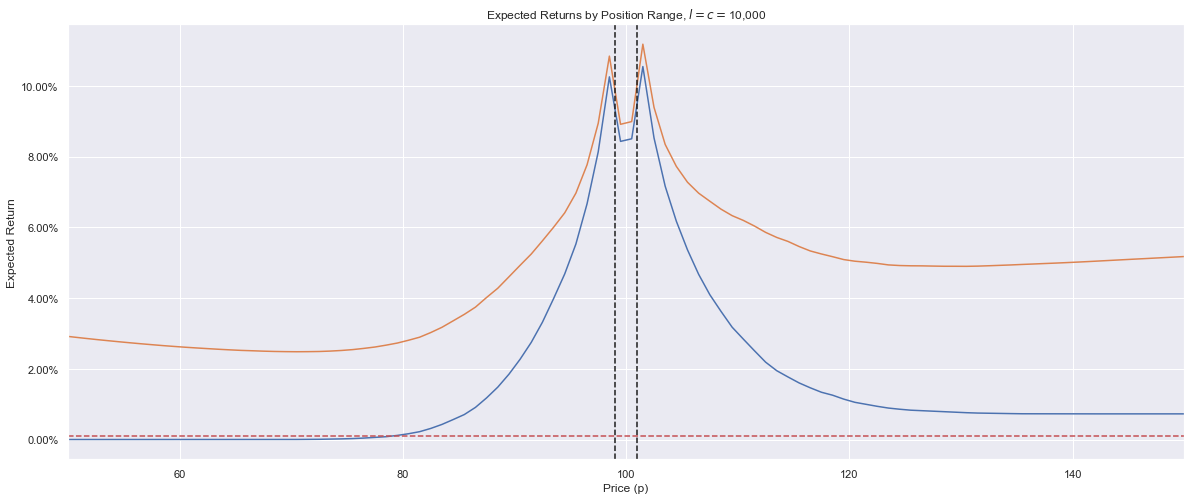

CPU times: user 4min 31s, sys: 10.5 s, total: 4min 42s
Wall time: 40min 58s


In [8]:
%%time
n_innovations = 5

num = 50 / n_innovations
size = 1000
mu = 0.0 / n_innovations
sigma = 0.1 / np.sqrt(n_innovations)

num_trades_dist = stats.poisson(num)
trade_size_dist = stats.expon(scale=size)
trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
return_dist = stats.norm(loc=mu, scale=sigma)

L = 10000
loc = 100
s = 10
c = L
liquidity_functions = [
    lambda x: L,
    lambda p: sech2_fn(p, loc, s, c)
]

fig, ax = plt.subplots(figsize=(20, 8))

for liquidity_fn in liquidity_functions:
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }
    
    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax)
    
ax.set_title(f'Expected Returns by Position Range, $l=c=${L:,.0f}')
ax.set_xlim(50, 150)
ax.axvline(init_price * (1 - fee), linestyle='--', color='k')
ax.axvline(init_price / (1 - fee), linestyle='--', color='k')
ax.axhline(sigma ** 2 / 2, linestyle='--', color='r')
ax.set_ylabel('Expected Return')
ax.set_xlabel('Price (p)')

fig.savefig('./images/sim_returns_7.png')
plt.show()

/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Courses/AFP/uniswap-v3-project/uniswapv3_simulator/optimization/traders.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (-alpha + np.sqrt((alpha + beta * q0) ** 2 + 2 * beta * dy)) / beta
/Users/pspalding/Desktop/Phil/MFE/Course

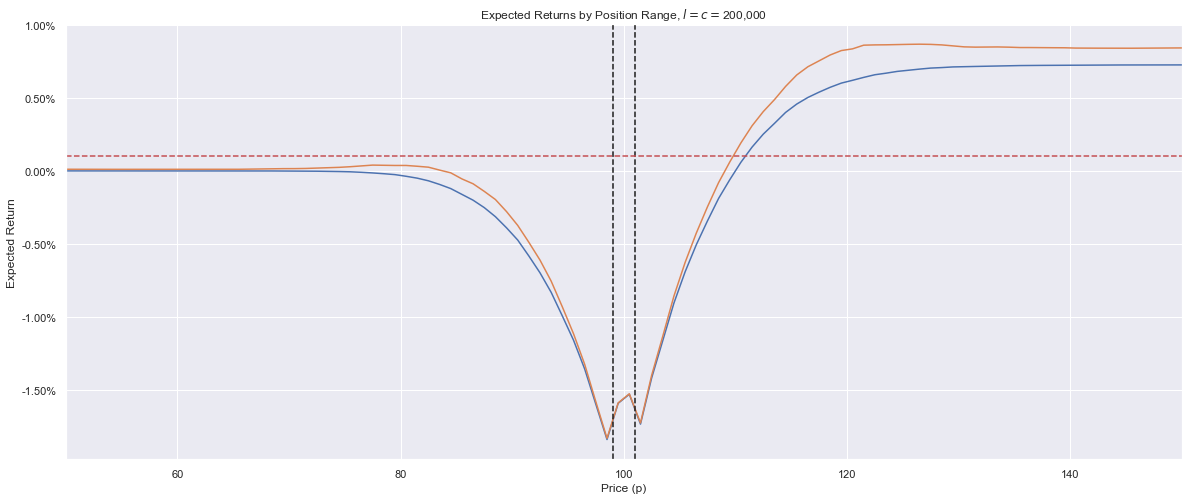

CPU times: user 5min, sys: 10.7 s, total: 5min 11s
Wall time: 25min 17s


In [9]:
%%time
n_innovations = 5

num = 50 / n_innovations
size = 1000
mu = 0.0 / n_innovations
sigma = 0.1 / np.sqrt(n_innovations)

num_trades_dist = stats.poisson(num)
trade_size_dist = stats.expon(scale=size)
trade_sign_dist = stats.rv_discrete(values=([-1, 1], [0.5, 0.5]))
return_dist = stats.norm(loc=mu, scale=sigma)

L = 200000
loc = 100
s = 10
c = L
liquidity_functions = [
    lambda x: L,
    lambda p: sech2_fn(p, loc, s, c)
]

fig, ax = plt.subplots(figsize=(20, 8))

for liquidity_fn in liquidity_functions:
    pool = Uniswapv3Pool(fee, 1, init_price)
    init_tokens = set_positions(pool, liquidity_fn, pos_width, 0, 200, separate_pos=True)
    init_values = {
        pid: calc_token_value(tdict['token0'], tdict['token1'], init_price)
        for pid, tdict in init_tokens.items()
    }
    
    sim_results = pool_simulation(
        pool, 
        num_trades_dist, 
        trade_size_dist,
        trade_sign_dist,
        return_dist,
        n_innovations=n_innovations, 
        n_sims=n_sims, 
        n_jobs=n_jobs, 
        seed=SEED
    )
    sim_returns = calc_returns(init_values, sim_results)
    plot_mean_returns(sim_returns, pos_width, ax=ax)
    
ax.set_title(f'Expected Returns by Position Range, $l=c=${L:,.0f}')
ax.set_xlim(50, 150)
ax.axvline(init_price * (1 - fee), linestyle='--', color='k')
ax.axvline(init_price / (1 - fee), linestyle='--', color='k')
ax.axhline(sigma ** 2 / 2, linestyle='--', color='r')
ax.set_ylabel('Expected Return')
ax.set_xlabel('Price (p)')

fig.savefig('./images/sim_returns_8.png')
plt.show()